## Let's make a map that shows the landslide sources on a topographic map

In [2]:
# Connect to google drive data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install rasterio

In [4]:
!pip install rasterstats

In [5]:
# Import libraries - vector data
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Polygon
import re
from shapely.wkt import dumps
import numpy as np

# Import libraries - Raster
import rasterio as rio
from rasterio.warp import calculate_default_transform
from rasterio.warp import reproject, Resampling
import os
import osgeo
from rasterio import plot, mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
import rasterstats

In [6]:
# Miscelaneous processes

# Path to the shapefile containing the landslide inventory
main_path = '/content/drive/MyDrive/MLGeo23_Landslide_FinalProject/data'

# open study area
study_area = gpd.read_file(main_path + '/study_area/king_county_sf.shp')

# open complete inventory
gdf = gpd.read_file(main_path + '/inventory/inventory_gdf.gpkg')

In [7]:
# open raster DEM and clip
raster_path = main_path + '/elevation/30m_wa_DEM_reproj.tif'
src = rio.open(raster_path)

# define geometry of reference
geom = study_area.geometry

# Getting extent of masked raster array
ls_extent = rio.plot.plotting_extent(src)

# clip for KC study area
rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}
ma, ma_transform = rio.mask.mask(src, geom, **rio_mask_kwargs)

#Get clipped extent in PROJ coordaintes for plotting
ma_extent = rio.plot.plotting_extent(ma, ma_transform)

In [8]:
# Calculate centroids for landslide geometries
gdf['centroid'] = gdf['geometry'].centroid
gdf['id'] = gdf['landslide_ID']

# Get x and y coordinates of centroids
centroid_data = gdf[['centroid', 'geometry']].copy()  # Create a copy of the necessary columns
centroid_data['centroid_x'] = centroid_data['centroid'].x
centroid_data['centroid_y'] = centroid_data['centroid'].y
ids = gdf['id'].copy()

# Extract required centroid data
centroid_df = centroid_data[['centroid_x', 'centroid_y']].copy()

In [9]:
centroid_df['centroid_x']

0       1.176081e+06
1       1.175912e+06
2       1.176080e+06
3       1.175979e+06
4       1.175842e+06
            ...     
2665    1.270287e+06
2666    1.269657e+06
2667    1.223674e+06
2668    1.209460e+06
2669    1.209594e+06
Name: centroid_x, Length: 2670, dtype: float64

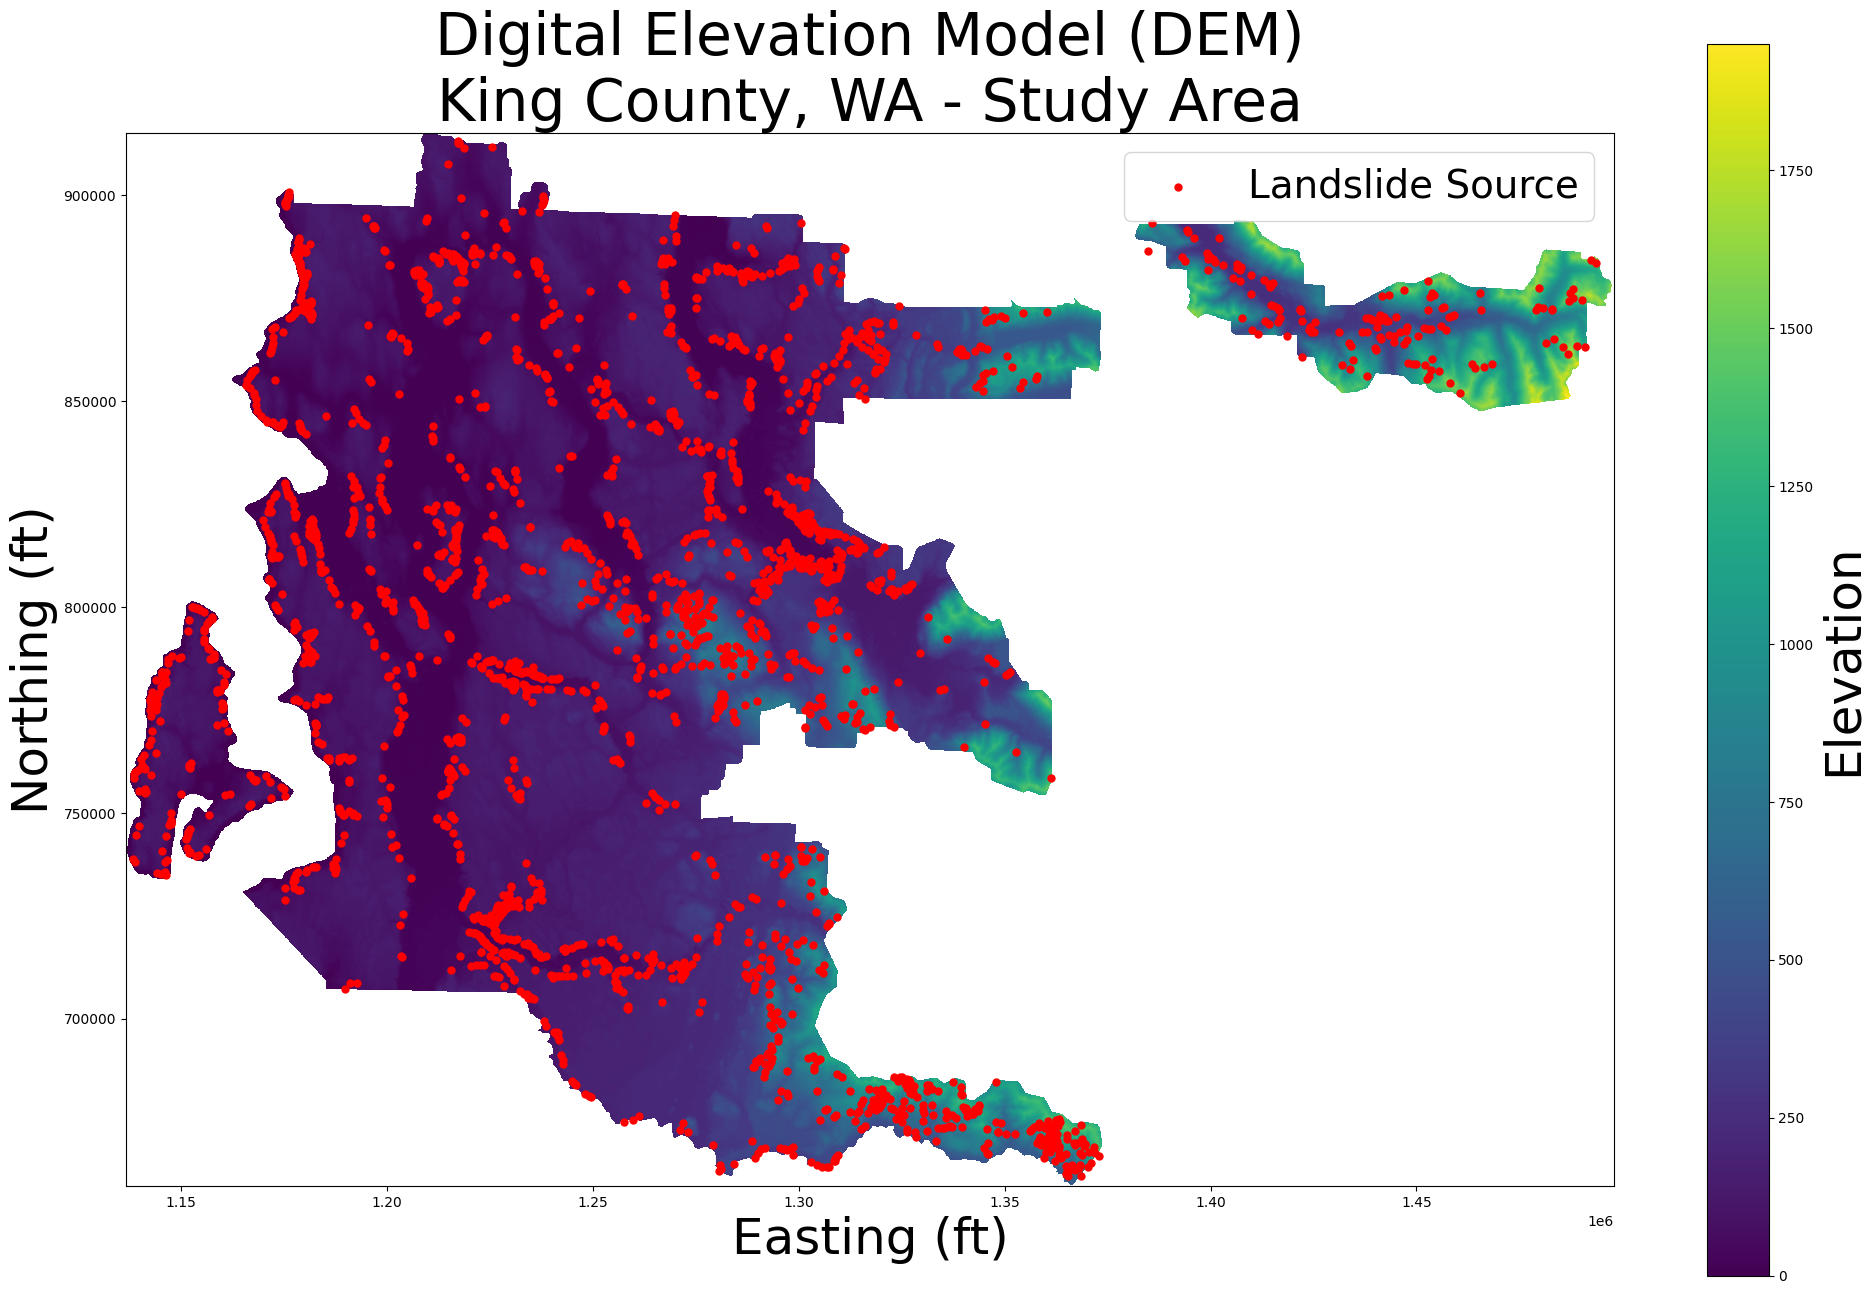

In [10]:
# Open rejected DEM
raster_reproj = rio.open(main_path + '/elevation/30m_wa_DEM_reproj.tif')

# define geometry of reference
geom = study_area.geometry

# Getting extent of masked raster array
ls_extent = rio.plot.plotting_extent(raster_reproj)

# clip for KC study area
rio_mask_kwargs = {'filled': False, 'crop': True, 'indexes': 1}
ma, ma_transform = rio.mask.mask(raster_reproj, geom, **rio_mask_kwargs)

# Get clipped extent in PROJ coordinates for plotting
ma_extent = rio.plot.plotting_extent(ma, ma_transform)

# Sanity check using or_ma
f, ax = plt.subplots(figsize=(24, 16))
map = ax.imshow(ma, extent=ma_extent, cmap='viridis')

# Scatter plot for centroid data
plt.scatter(centroid_df['centroid_x'], centroid_df['centroid_y'], color='red', linewidth=0.00001, label='Landslide Source')

# Title and axis labels with larger font size
plt.title('Digital Elevation Model (DEM)\nKing County, WA - Study Area', fontsize=42)
plt.xlabel('Easting (ft)', fontsize=36)
plt.ylabel('Northing (ft)', fontsize=36)
plt.legend(fontsize=28)

# Color bar with a label and increased font size
colorbar = f.colorbar(map, ax=ax)
colorbar.set_label('Elevation', fontsize=36)

# Save the figure
path = '/content/drive/MyDrive/MLGeo23_Landslide_FinalProject/deliverables/'
plt.savefig(path + 'elevation_map_with_landslides.png', bbox_inches='tight')


In [ ]:
import rasterio
from rasterio.enums import Resampling
from rasterio.plot import show
from rasterio.windows import Window
from rasterio import shutil as rio_shutil

# Path to your input DEM file
input_dem = raster_reproj

# Path to save the output hillshade file
output_hillshade = '_hs.tif'

# Open the DEM file
with rasterio.open(input_dem) as src:
    # Read the DEM data
    dem_data = src.read(1)

    # Calculate the hillshade using gdaldem algorithm (if available in your system)
    # Install gdal if you haven't already: pip install gdal
    rio_shutil.copy(input_dem, output_hillshade, driver='GTiff')  # Copy the DEM to create the output file

    # You may need to specify the full path to gdaldem if it's not in your system's PATH
    gdaldem_cmd = 'gdaldem hillshade {} {} -z 1.0 -s 1.0 -az 315 -alt 45 -compute_edges'.format(input_dem, output_hillshade)
    os.system(gdaldem_cmd)  # Execute the gdaldem hillshade command

# Open and display the generated hillshade file
with rasterio.open(output_hillshade) as hillshade_src:
    hillshade_data = hillshade_src.read(1)
    show(hillshade_data, cmap='gray')